# Decision Tree - Fraud Check

### Problem Statement:
Use decision trees to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

#### Input variables:

+ Undergrad : person is under graduated or not
+ Marital.Status : marital status of a person
+ Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
+ Work Experience : Work experience of an individual person
+ Urban : Whether that person belongs to urban area or not

### Step-1 : Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings as warnings
warnings.filterwarnings("ignore")
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from collections import Counter
from sklearn import metrics
!pip install imblearn
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Step-2 : Descriptive analysis

### Step-2.1 : Working with Dataset

#### Loading the Dataset

In [2]:
# Importing the dataset
fraud_data = pd.read_csv("Fraud_check.csv")

#### Exploring the dataset

In [3]:
# Displaying first ten records
fraud_data.head(10)

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   
5        NO       Divorced           33329           116382                0   
6        NO       Divorced           83357            80890                8   
7       YES         Single           62774           131253                3   
8        NO         Single           83519           102481               12   
9       YES       Divorced           98152           155482                4   

  Urban  
0   YES  
1   YES  
2   YES  
3   YES  
4    NO  
5    NO  
6   YES  
7   YES  
8   YES  
9   YES

In [4]:
# Shape of the data
fraud_data.shape

(600, 6)

In [5]:
# Summary of the data
fraud_data.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

In [6]:
# Check the data types
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


#### Modifying the dataset

In [7]:
fraud_data = fraud_data.rename(columns={"Undergrad":"Under_grad","Marital.Status":"Marital","Taxable.Income":"Tax_income","City.Population":"City_pop","Work.Experience":"Work_exp"})
fraud_data

Under_grad   Marital  Tax_income  City_pop  Work_exp Urban
0           NO    Single       68833     50047        10   YES
1          YES  Divorced       33700    134075        18   YES
2           NO   Married       36925    160205        30   YES
3          YES    Single       50190    193264        15   YES
4           NO   Married       81002     27533        28    NO
..         ...       ...         ...       ...       ...   ...
595        YES  Divorced       76340     39492         7   YES
596        YES  Divorced       69967     55369         2   YES
597         NO  Divorced       47334    154058         0   YES
598        YES   Married       98592    180083        17    NO
599         NO  Divorced       96519    158137        16    NO

[600 rows x 6 columns]

### Step-2.2 : Handling missing values

In [8]:
# Check for Null values
fraud_data.isnull().sum()

Under_grad    0
Marital       0
Tax_income    0
City_pop      0
Work_exp      0
Urban         0
dtype: int64

In [9]:
# Check for duplicate values
fraud_data[fraud_data.duplicated()].shape

(0, 6)

In [10]:
fraud_data[fraud_data.duplicated()]

Empty DataFrame
Columns: [Under_grad, Marital, Tax_income, City_pop, Work_exp, Urban]
Index: []

### Step-2.3 : Feature Engineering

In [11]:
fraud_data.Tax_income.describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Tax_income, dtype: float64

####  Let us  assume  that  taxable income <= 30000 as “Risky=0” and others are “Good=1”

In [12]:
# Including a column "Tax_income_cat" which is the Taxable income category dividing the Taxable income into three categories
fraud_data['Tax_income_cat'] = pd.cut(x = fraud_data['Tax_income'], bins = [10002,30000,99620], labels=['Risky','Good'], right = False)
fraud_data.head()

Under_grad   Marital  Tax_income  City_pop  Work_exp Urban Tax_income_cat
0         NO    Single       68833     50047        10   YES           Good
1        YES  Divorced       33700    134075        18   YES           Good
2         NO   Married       36925    160205        30   YES           Good
3        YES    Single       50190    193264        15   YES           Good
4         NO   Married       81002     27533        28    NO           Good

In [13]:
fraud_data.Tax_income_cat.value_counts()

Good     476
Risky    124
Name: Tax_income_cat, dtype: int64

### Step-2.4 : Exploring data using Visualisation

#### Differentiate Categorical and Numerical features

In [14]:
fraud_data_cat = fraud_data.select_dtypes(include=['object','category'])
fraud_data_cat

Under_grad   Marital Urban Tax_income_cat
0           NO    Single   YES           Good
1          YES  Divorced   YES           Good
2           NO   Married   YES           Good
3          YES    Single   YES           Good
4           NO   Married    NO           Good
..         ...       ...   ...            ...
595        YES  Divorced   YES           Good
596        YES  Divorced   YES           Good
597         NO  Divorced   YES           Good
598        YES   Married    NO           Good
599         NO  Divorced    NO           Good

[600 rows x 4 columns]

In [15]:
fraud_data_num = fraud_data.select_dtypes(include=['int64'])
fraud_data_num

Tax_income  City_pop  Work_exp
0         68833     50047        10
1         33700    134075        18
2         36925    160205        30
3         50190    193264        15
4         81002     27533        28
..          ...       ...       ...
595       76340     39492         7
596       69967     55369         2
597       47334    154058         0
598       98592    180083        17
599       96519    158137        16

[600 rows x 3 columns]

#### Differentiate Discrete and Continuous features
+ Numerical variables are usually of 2 types 
+ Discrete features and continuous features

In [16]:
discrete_feature=[feature for feature in fraud_data_num.columns if len(fraud_data[feature].unique())<10]
discrete_feature

[]

In [17]:
continuous_feature=[feature for feature in fraud_data_num.columns if feature not in discrete_feature]
continuous_feature

['Tax_income', 'City_pop', 'Work_exp']

In [18]:
fraud_data_cont = fraud_data_num[continuous_feature]
fraud_data_cont

Tax_income  City_pop  Work_exp
0         68833     50047        10
1         33700    134075        18
2         36925    160205        30
3         50190    193264        15
4         81002     27533        28
..          ...       ...       ...
595       76340     39492         7
596       69967     55369         2
597       47334    154058         0
598       98592    180083        17
599       96519    158137        16

[600 rows x 3 columns]

#### Univariate Analysis

#### Histogram

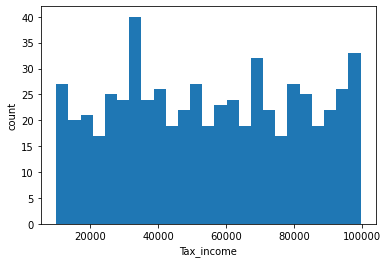

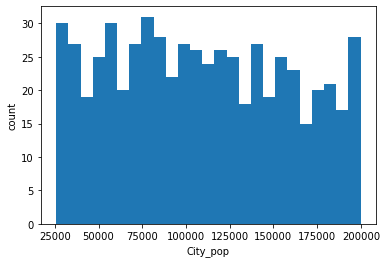

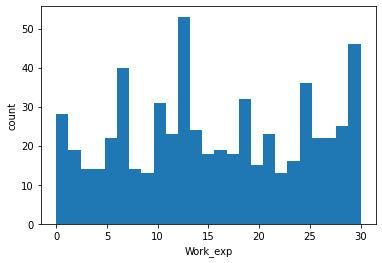

In [19]:
for feature in fraud_data_cont.columns:
    plt.figure()
    plt.hist(fraud_data_cont[feature],bins=25)
    plt.xlabel(feature)
    plt.ylabel("count")

#### Boxplot

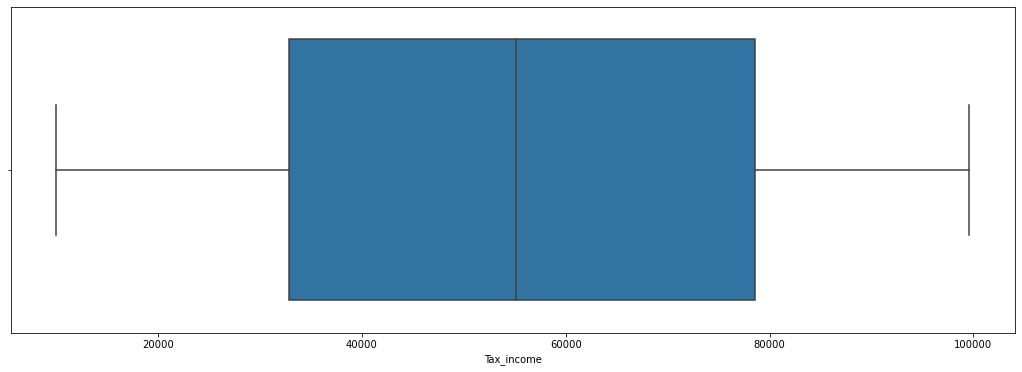

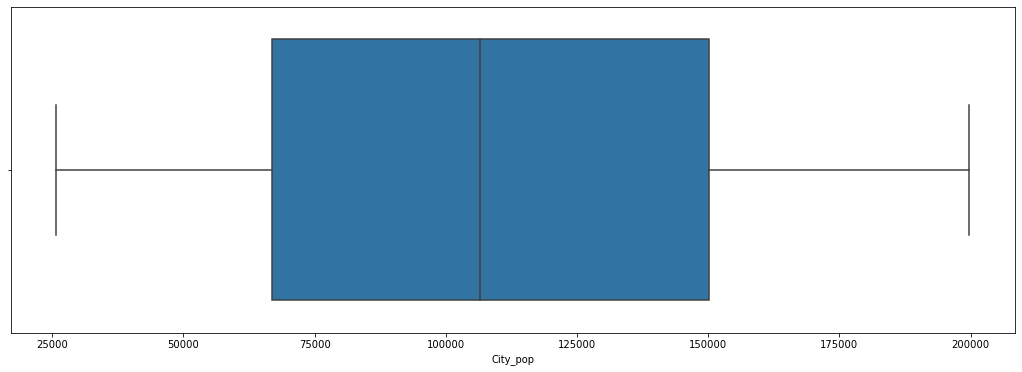

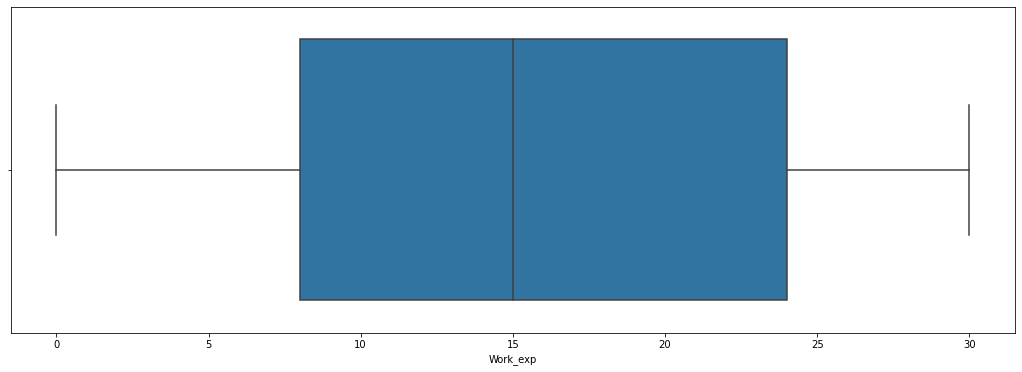

In [20]:
for feature in fraud_data_cont.columns:
    plt.figure(figsize=(18,6))
    sb.boxplot(fraud_data_cont[feature])

<AxesSubplot:>

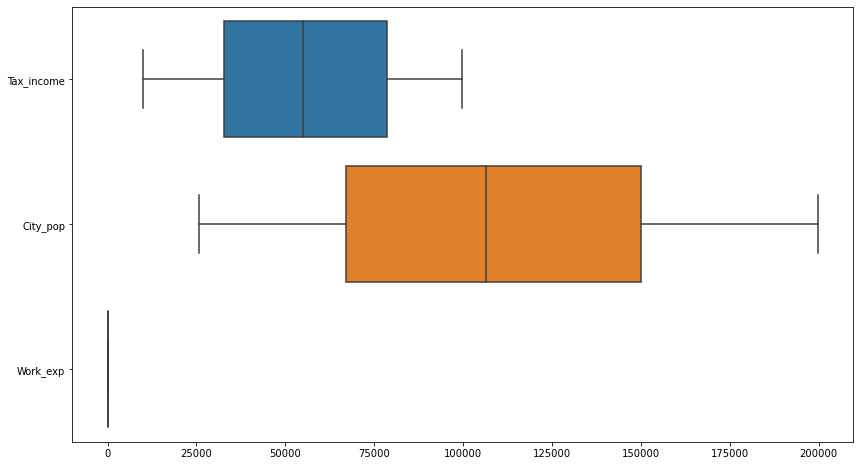

In [21]:
plt.figure(figsize=(14,8))
sb.boxplot(data=fraud_data_num, orient='h')

#### Multivariate Analysis

#### Correlation and Heat map

In [22]:
# Checking for Correlation between variables
fraud_data_cont.corr()

Tax_income  City_pop  Work_exp
Tax_income    1.000000 -0.064387 -0.001818
City_pop     -0.064387  1.000000  0.013135
Work_exp     -0.001818  0.013135  1.000000

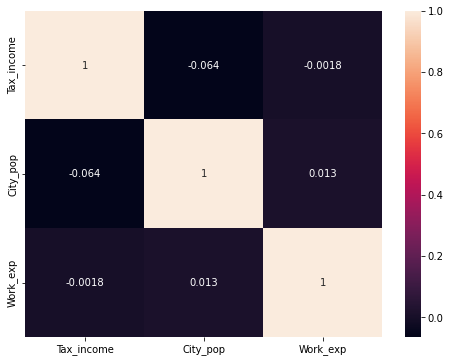

In [23]:
plt.figure(figsize=(8,6))
sb.heatmap(fraud_data_cont.corr(),annot=True)
plt.show()

<Figure size 576x576 with 0 Axes>

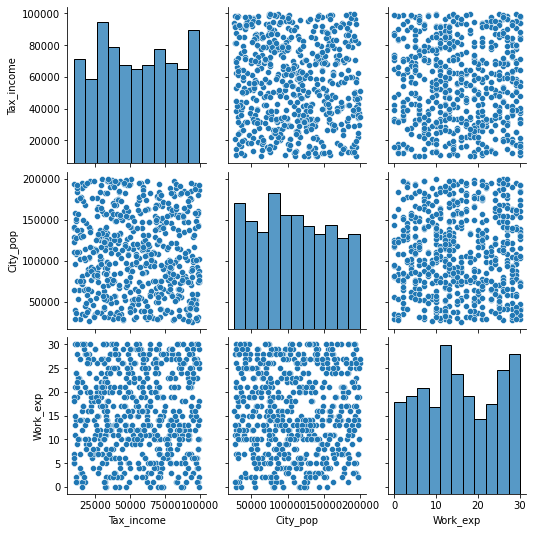

In [24]:
plt.figure(figsize=(8,8))
sb.pairplot(fraud_data, palette='coolwarm')
plt.show()

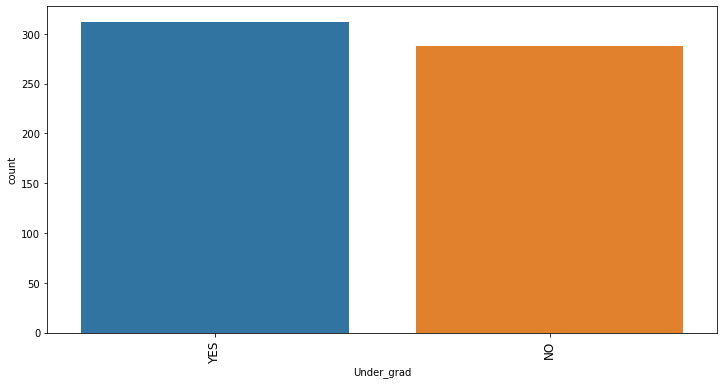

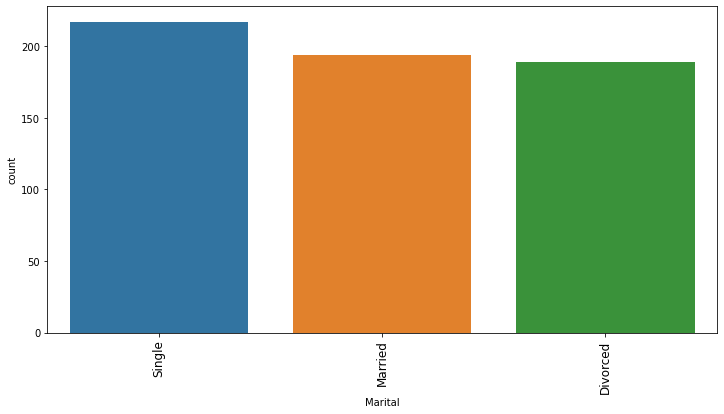

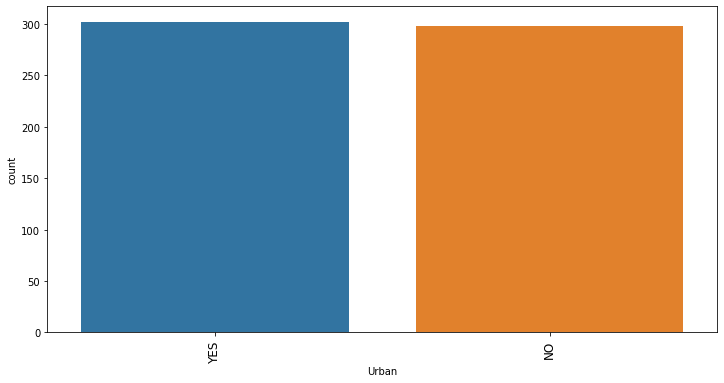

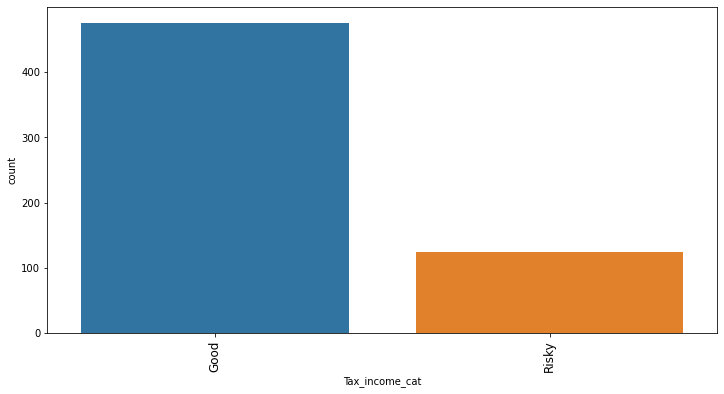

In [25]:
for i in fraud_data_cat.columns:
    plt.figure(figsize=(12,6))
    sb.countplot(x=i, data=fraud_data_cat, 
              order=fraud_data_cat[i].value_counts().index)
    plt.xticks(rotation = 90,fontsize = 12)
plt.show()

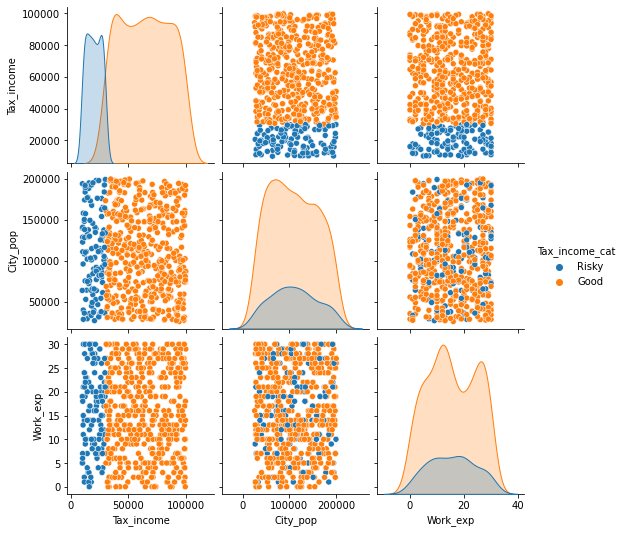

In [26]:
sb.pairplot(data=fraud_data, hue = 'Tax_income_cat')

<Figure size 864x432 with 0 Axes>

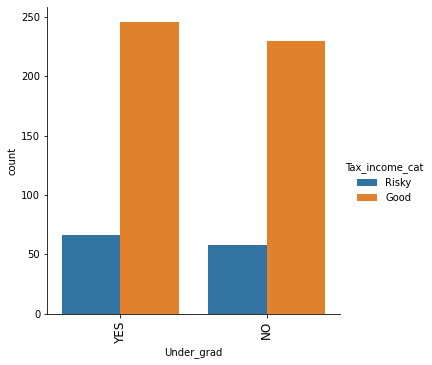

<Figure size 864x432 with 0 Axes>

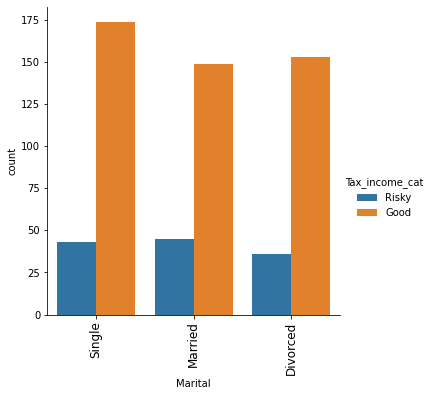

<Figure size 864x432 with 0 Axes>

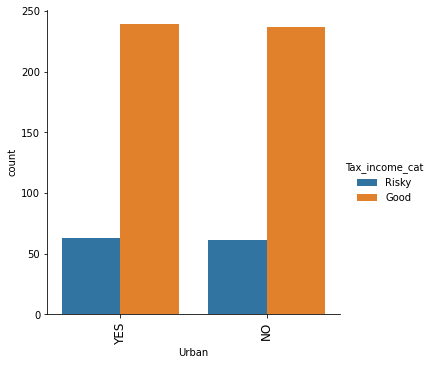

<Figure size 864x432 with 0 Axes>

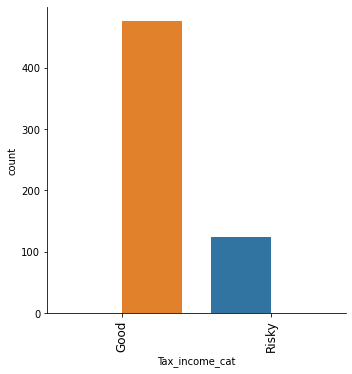

In [27]:
for i in fraud_data_cat.columns:
    plt.figure(figsize=(12,6))
    sb.catplot(data=fraud_data_cat,x=i,hue="Tax_income_cat",kind='count',
              order=fraud_data_cat[i].value_counts().index)
    plt.xticks(rotation = 90,fontsize = 12)
plt.show()

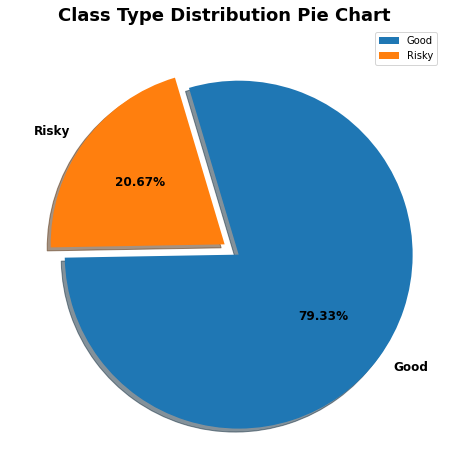

In [28]:
plt.figure(figsize = (12,8))
plt.pie(fraud_data['Tax_income_cat'].value_counts(),
       labels=fraud_data.Tax_income_cat.unique(),
       explode = [0.1,0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 181,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

### Step-3 : Data Pre-Processing

#### Converting categorical variables into numerical using Label encoder

In [29]:
fraud_data_mdf = fraud_data.copy()
fraud_data_mdf.drop('Tax_income', axis=1, inplace = True)

In [30]:
le = LabelEncoder()
for col in fraud_data_cat.columns:
        le.fit(fraud_data_mdf[col])
        fraud_data_mdf[col] = le.transform(fraud_data_mdf[col])
fraud_data_mdf.head()

Under_grad  Marital  City_pop  Work_exp  Urban  Tax_income_cat
0           0        2     50047        10      1               0
1           1        0    134075        18      1               0
2           0        1    160205        30      1               0
3           1        2    193264        15      1               0
4           0        1     27533        28      0               0

### Step-4 : Feature Selection

### Step-4.1 : Split the data into training and testing data

In [31]:
x = fraud_data_mdf.drop('Tax_income_cat', 1)
y = fraud_data_mdf['Tax_income_cat']

In [32]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state=42)

In [34]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Step-5 : Build a Decision Tree model

### Step-5.1 : Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [35]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [36]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_X, train_y)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=True)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.794444    0.0  0.794444    0.397222      0.631142
recall       1.000000    0.0  0.794444    0.500000      0.794444
f1-score     0.885449    0.0  0.794444    0.442724      0.703440
support    429.000000  111.0  0.794444  540.000000    540.000000
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [111   0]]

Test Result:
Accuracy Score: 78.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.783333   0.0  0.783333   0.391667      0.613611
recall      1.000000   0.0  0.783333   0.500000      0.7

In [37]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = cross_val_score(decision_tree, train_X, train_y, cv=skf)
print(results.mean())

0.6555555555555556


In [38]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(train_X,train_y)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [39]:
grid.best_score_

0.7944444444444444

In [40]:
predict_output = model.predict(test_X)
accuracy_test = accuracy_score(test_y,predict_output)
accuracy_test

0.7833333333333333

<AxesSubplot:>

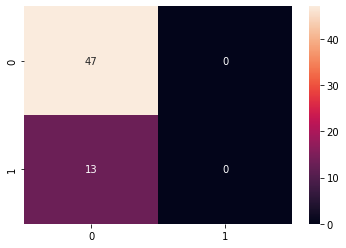

In [41]:
sb.heatmap(confusion_matrix(test_y, predict_output),annot=True)

In [42]:
print(classification_report(test_y,predict_output))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



### Step-5.2 : Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [43]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 80.71%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.804348   1.000000  0.807143    0.902174      0.844876
recall       1.000000   0.068966  0.807143    0.534483      0.807143
f1-score     0.891566   0.129032  0.807143    0.510299      0.733613
support    333.000000  87.000000  0.807143  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [ 81   6]]

Test Result:
Accuracy Score: 78.89%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.793296   0.0  0.788889    0.396648      0.630230
recall       0.993007   0.0  0.7

In [44]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf)
print(results.mean())

0.5928571428571427


In [45]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(x_train,y_train)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [46]:
grid.best_score_

0.7928571428571429

In [47]:
predict_output = model.predict(x_test)
accuracy_test = accuracy_score(y_test,predict_output)
accuracy_test

0.7944444444444444

<AxesSubplot:>

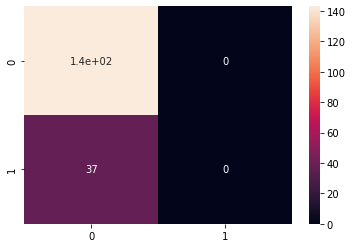

In [48]:
sb.heatmap(confusion_matrix(y_test, predict_output),annot=True)

In [49]:
print(classification_report(y_test,predict_output))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



#### Observation: 
+ In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

### Step-6 : Handling imbalance data using SMOTE based techniques

In [50]:
x = fraud_data_mdf.drop(['Tax_income_cat'], axis=1)
y = fraud_data_mdf['Tax_income_cat']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=42,stratify=y)

In [51]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Step-6.1 : SMOTE Oversampling technique

In [52]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


### Step-6.2 : ADASYN: Adaptive Synthetic Sampling Approach

In [53]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=42)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 323})


### Step-6.3 : Hybridization: SMOTE + Tomek Links

In [54]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=42)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 255, 1: 255})


### Step-6.4 : Hybridization: SMOTE + ENN

In [55]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 76, 0: 70})


### Step-6.5 : Performance Analysis after Resampling

In [56]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [57]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [58]:
model_params = {
    'decision_tree' :{
        'model' :  DecisionTreeClassifier(),
        'params' : {
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']
        }
        
    }
    
}

In [59]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
decision_tree with ACTUAL
Confusion Matrix
[[135   8]
 [ 33   4]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       143
           1       0.33      0.11      0.16        37

    accuracy                           0.77       180
   macro avg       0.57      0.53      0.52       180
weighted avg       0.71      0.77      0.72       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
decision_tree with SMOTE
Confusion Matrix
[[97 46]
 [25 12]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       143
           1       0.21      0.32      0.25        37

    accuracy                           0.61       180
   macro avg       0.50      0.50      0.49       180
weighted avg       0.67      0.61      0.63       180
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

#### As per the above results, we can observe that ADASYN technique gave the best results. Hence use this.

In [60]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=42)
x_train_ada, y_train_ada = ada.fit_resample(x, y)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 476, 1: 124})
After Counter({1: 487, 0: 476})


In [61]:
x_train,x_test,y_train,y_test = train_test_split(x_train_smtom,y_train_smtom,test_size=0.3,random_state=42, stratify=y_train_smtom)

counter = Counter(y_train_smtom)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Before Counter({0: 255, 1: 255})
After Counter({1: 179, 0: 178})
Shape of X_train:  (357, 5)
Shape of X_test:  (153, 5)
Shape of y_train:  (357,)
Shape of y_test (153,)


### Step-7 : Pruning

In [62]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 6))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 6)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best paramters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'})
Train Result:
Accuracy Score: 73.11%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.713542    0.751515  0.731092    0.732528      0.732582
recall       0.769663    0.692737  0.731092    0.731200      0.731092
f1-score     0.740541    0.720930  0.731092    0.730735      0.730708
support    178.000000  179.000000  0.731092  357.000000    357.000000
_______________________________________________
Confusion Matrix: 
 [[137  41]
 [ 55 124]]

Test Result:
Accuracy Score: 64.71%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.632184   0.666667  0.647059    0.649425      0.649313
recall      0.7142

#### This is a balanced state of training and testing accuracy are close to each other where there is no overfitting or underfitting yet we can do better than this, let's try post pruning technique using alpha values.

### Step-7.1 : Building Decision Tree Classifier using Entropy Criteria with Alpha values Post Pruning

In [63]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

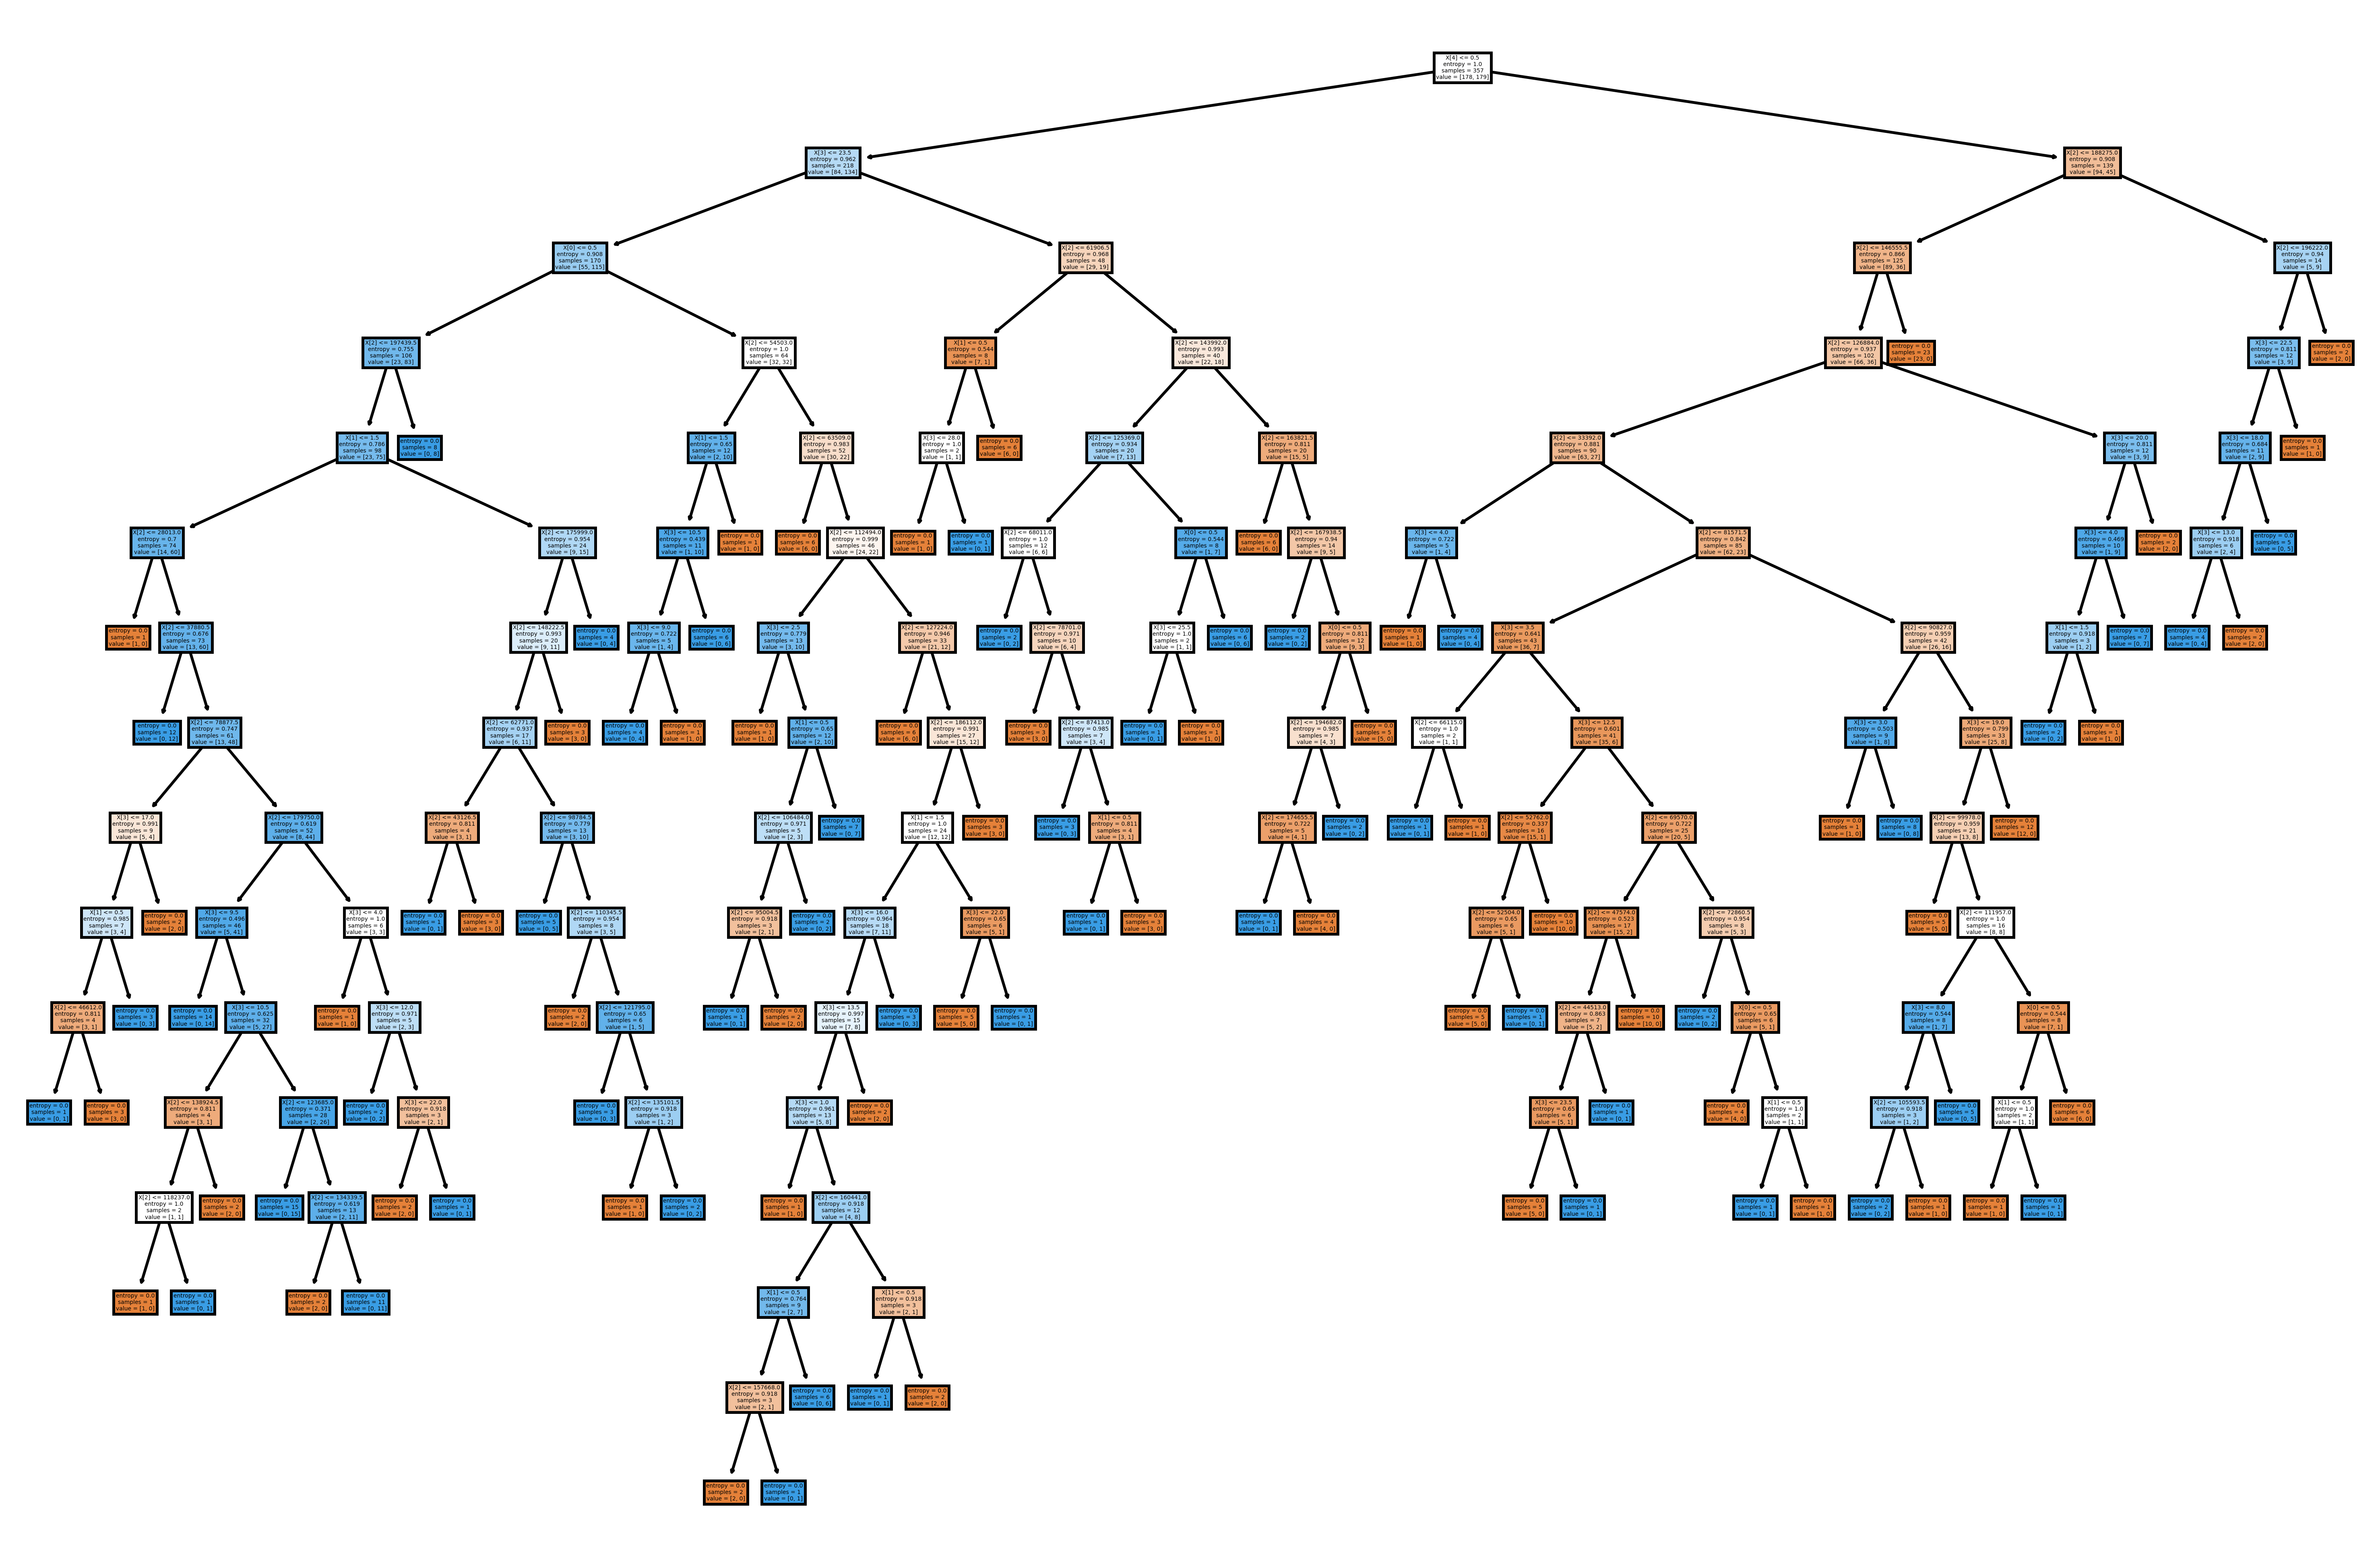

In [64]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [65]:
#Predicting on test data
preds = model_entropy.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1    90
0    63
dtype: int64

In [66]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0            0   1
Tax_income_cat        
0               47  30
1               16  60

In [67]:
# Accuracy 
np.mean(preds==y_test)

0.6993464052287581

In [68]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.75      0.61      0.67        77
           1       0.67      0.79      0.72        76

    accuracy                           0.70       153
   macro avg       0.71      0.70      0.70       153
weighted avg       0.71      0.70      0.70       153



In [69]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [70]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.059037377964764715


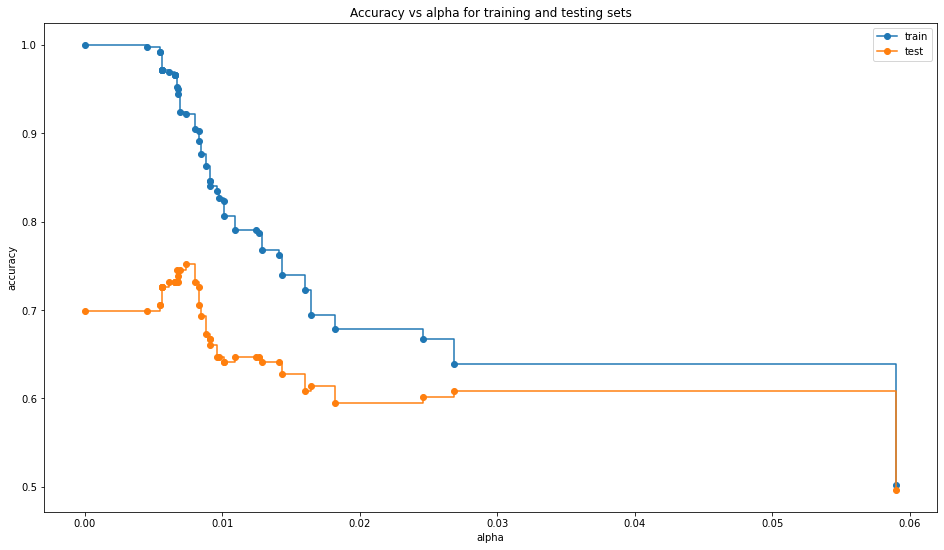

In [71]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [72]:
ccp_alphas

array([0.        , 0.00454498, 0.00546237, 0.00546237, 0.00560224,
       0.00560224, 0.00560224, 0.00560224, 0.00560224, 0.00609036,
       0.00656857, 0.00657847, 0.00657847, 0.00657847, 0.00674151,
       0.00677096, 0.00679937, 0.00694414, 0.00739047, 0.00802961,
       0.00830757, 0.00832837, 0.00841962, 0.00878211, 0.00908995,
       0.00908995, 0.00908995, 0.00960411, 0.00978021, 0.01011104,
       0.01012702, 0.01090144, 0.01245865, 0.01268718, 0.01288212,
       0.01413272, 0.01437322, 0.01601669, 0.01644514, 0.01817522,
       0.02459943, 0.02686004, 0.05903738])

In [73]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=42, ccp_alpha=0.01011104)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.01011104, criterion='entropy',
                       random_state=42)

In [74]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.8235294117647058 
Testing Accuracy 0.6405228758169934


<AxesSubplot:>

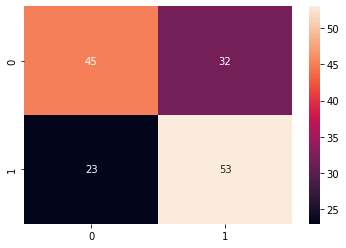

In [75]:
sb.heatmap(confusion_matrix(y_test, pred_test),annot=True)

In [76]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62        77
           1       0.62      0.70      0.66        76

    accuracy                           0.64       153
   macro avg       0.64      0.64      0.64       153
weighted avg       0.64      0.64      0.64       153



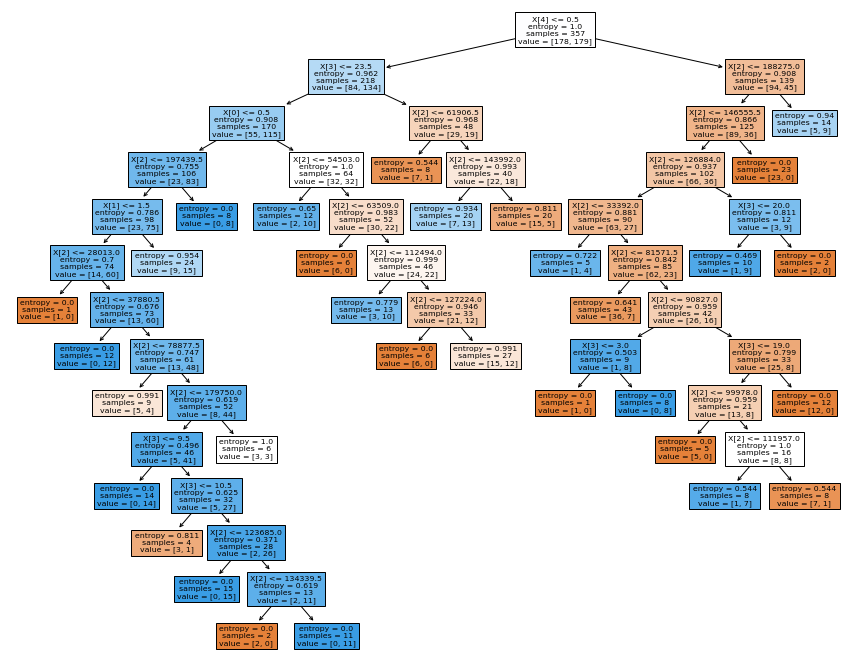

In [77]:
plt.figure(figsize=(15,12))
tree.plot_tree(clf,filled=True)
plt.show()

[Text(0.6547619047619048, 0.9642857142857143, 'Urban <= 0.5\nentropy = 1.0\nsamples = 357\nvalue = [178, 179]\nclass = Good'),
 Text(0.40476190476190477, 0.8928571428571429, 'Work_exp <= 23.5\nentropy = 0.962\nsamples = 218\nvalue = [84, 134]\nclass = Good'),
 Text(0.2857142857142857, 0.8214285714285714, 'Under_grad <= 0.5\nentropy = 0.908\nsamples = 170\nvalue = [55, 115]\nclass = Good'),
 Text(0.19047619047619047, 0.75, 'City_pop <= 197439.5\nentropy = 0.755\nsamples = 106\nvalue = [23, 83]\nclass = Good'),
 Text(0.14285714285714285, 0.6785714285714286, 'Marital <= 1.5\nentropy = 0.786\nsamples = 98\nvalue = [23, 75]\nclass = Good'),
 Text(0.09523809523809523, 0.6071428571428571, 'City_pop <= 28013.0\nentropy = 0.7\nsamples = 74\nvalue = [14, 60]\nclass = Good'),
 Text(0.047619047619047616, 0.5357142857142857, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Risky'),
 Text(0.14285714285714285, 0.5357142857142857, 'City_pop <= 37880.5\nentropy = 0.676\nsamples = 73\nvalue = [13, 6

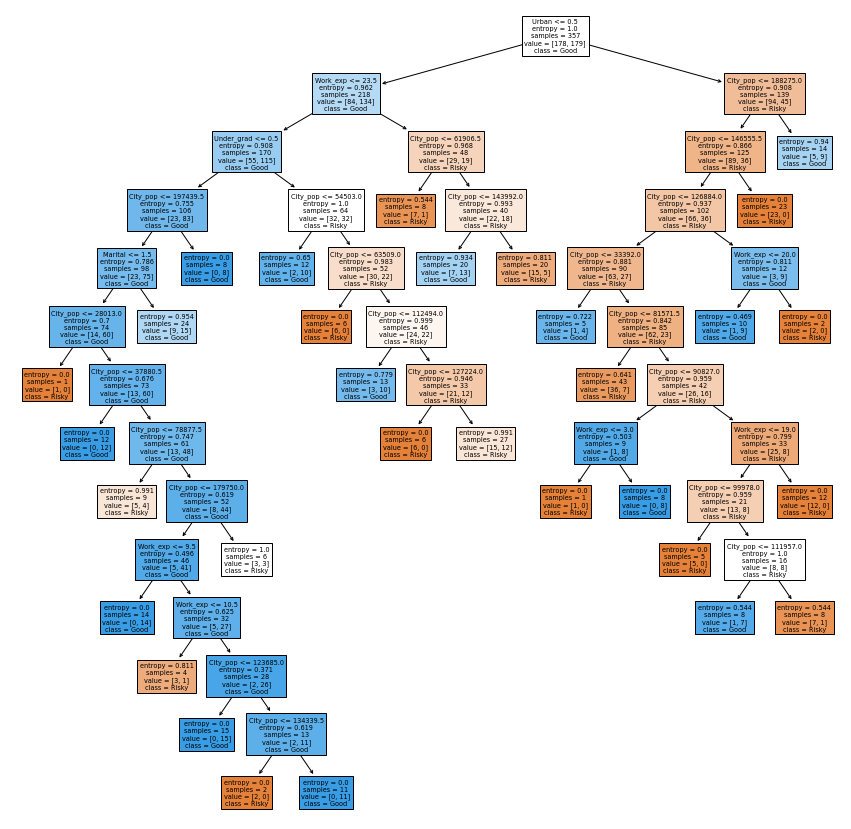

In [78]:
fn = x_train.columns
cn = ['Risky','Good']
plt.figure(figsize=(15,15))
tree.plot_tree(clf, feature_names=fn, class_names=cn, filled=True)

In [79]:
clf.feature_importances_ 

array([0.05968665, 0.01347807, 0.61213871, 0.19374835, 0.12094822])

In [80]:
feature_imp = pd.Series(clf.feature_importances_,index=fn).sort_values(ascending=False) 
feature_imp

City_pop      0.612139
Work_exp      0.193748
Urban         0.120948
Under_grad    0.059687
Marital       0.013478
dtype: float64

### Step-7.2 : Building Decision Tree Classifier using Gini Criteria with Alpha values Post Pruning

In [81]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

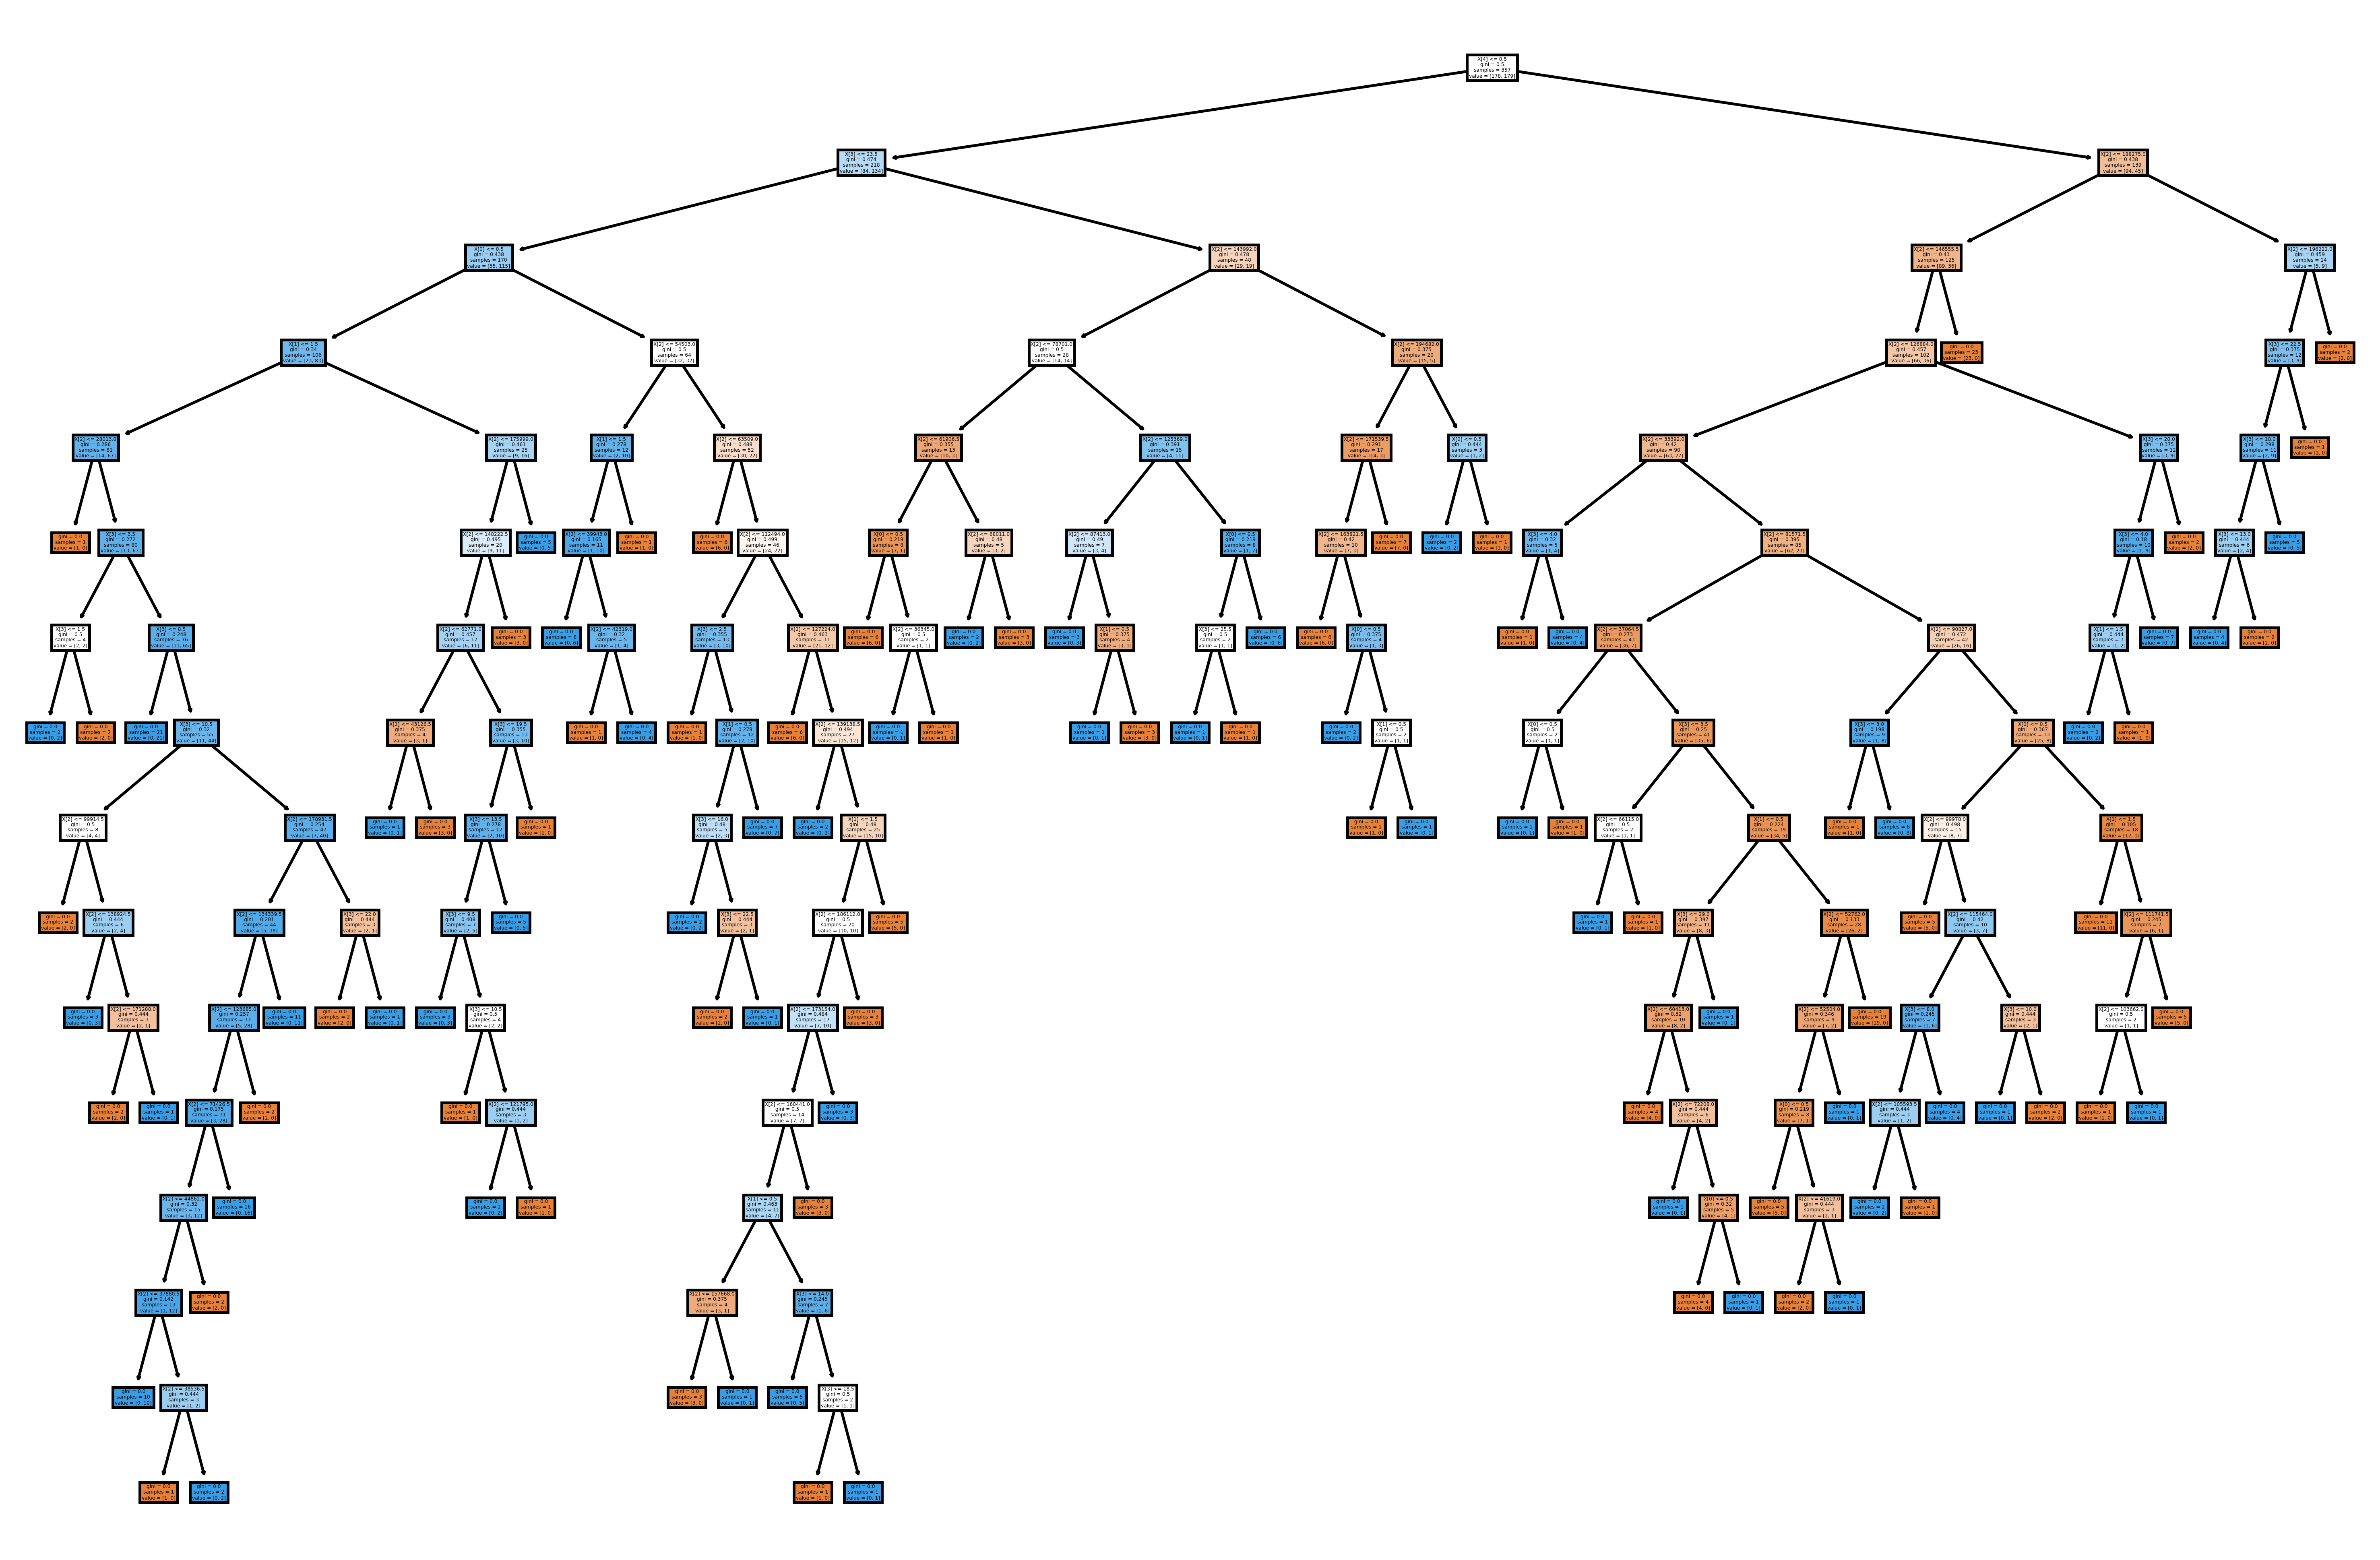

In [82]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_gini,filled=True)
plt.show()

In [83]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1    90
0    63
dtype: int64

In [84]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0            0   1
Tax_income_cat        
0               43  34
1               20  56

In [85]:
# Accuracy 
np.mean(preds==y_test)

0.6470588235294118

In [86]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61        77
           1       0.62      0.74      0.67        76

    accuracy                           0.65       153
   macro avg       0.65      0.65      0.64       153
weighted avg       0.65      0.65      0.64       153



In [87]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [88]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.04024995809912141


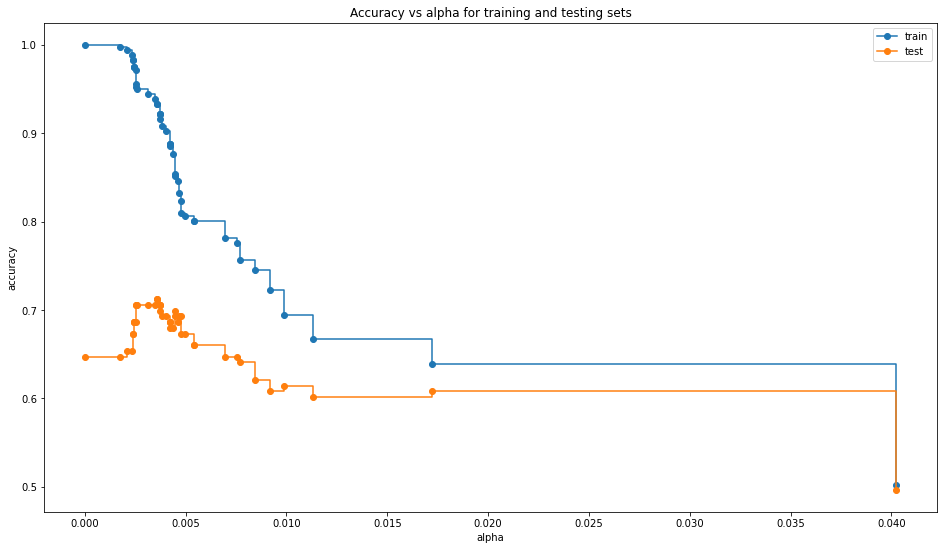

In [89]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [90]:
ccp_alphas

array([0.        , 0.00176367, 0.00210084, 0.00233427, 0.00240096,
       0.00240096, 0.00245098, 0.00245098, 0.00245098, 0.00252101,
       0.00253907, 0.00254647, 0.00258565, 0.00311236, 0.00348139,
       0.00359118, 0.00359118, 0.00373483, 0.00373483, 0.00373483,
       0.00373483, 0.00384376, 0.00401314, 0.00420168, 0.00420168,
       0.00420168, 0.00424412, 0.0043573 , 0.00447647, 0.00448179,
       0.00461995, 0.00468815, 0.00475599, 0.00476007, 0.00497977,
       0.00540216, 0.00543248, 0.00696958, 0.00756303, 0.00769818,
       0.00844863, 0.00919342, 0.00987869, 0.01133029, 0.01721128,
       0.04024996])

In [91]:
clf = DecisionTreeClassifier(criterion='gini',random_state=42, ccp_alpha=0.00696958)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00696958, random_state=42)

In [92]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.8011204481792717 
Testing Accuracy 0.6601307189542484


<AxesSubplot:>

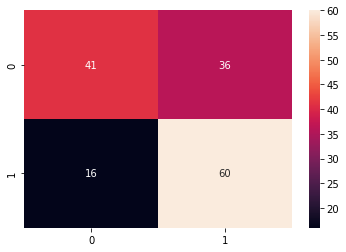

In [93]:
sb.heatmap(confusion_matrix(y_test, pred_test),annot=True)

In [94]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.72      0.53      0.61        77
           1       0.62      0.79      0.70        76

    accuracy                           0.66       153
   macro avg       0.67      0.66      0.65       153
weighted avg       0.67      0.66      0.65       153



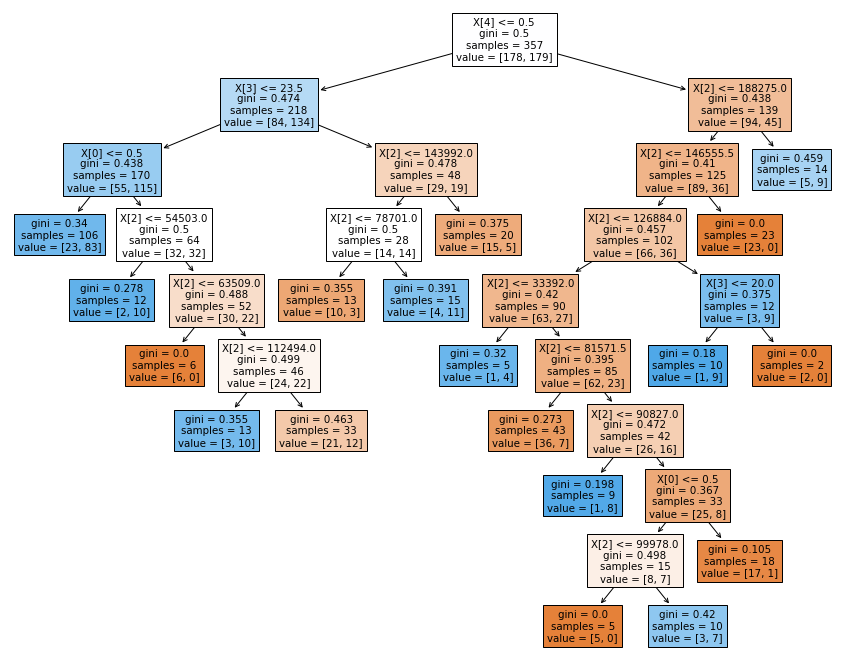

In [95]:
plt.figure(figsize=(15,12))
tree.plot_tree(clf,filled=True)
plt.show()

[Text(0.59375, 0.95, 'Urban <= 0.5\ngini = 0.5\nsamples = 357\nvalue = [178, 179]\nclass = Good'),
 Text(0.3125, 0.85, 'Work_exp <= 23.5\ngini = 0.474\nsamples = 218\nvalue = [84, 134]\nclass = Good'),
 Text(0.125, 0.75, 'Under_grad <= 0.5\ngini = 0.438\nsamples = 170\nvalue = [55, 115]\nclass = Good'),
 Text(0.0625, 0.65, 'gini = 0.34\nsamples = 106\nvalue = [23, 83]\nclass = Good'),
 Text(0.1875, 0.65, 'City_pop <= 54503.0\ngini = 0.5\nsamples = 64\nvalue = [32, 32]\nclass = Risky'),
 Text(0.125, 0.55, 'gini = 0.278\nsamples = 12\nvalue = [2, 10]\nclass = Good'),
 Text(0.25, 0.55, 'City_pop <= 63509.0\ngini = 0.488\nsamples = 52\nvalue = [30, 22]\nclass = Risky'),
 Text(0.1875, 0.45, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = Risky'),
 Text(0.3125, 0.45, 'City_pop <= 112494.0\ngini = 0.499\nsamples = 46\nvalue = [24, 22]\nclass = Risky'),
 Text(0.25, 0.35, 'gini = 0.355\nsamples = 13\nvalue = [3, 10]\nclass = Good'),
 Text(0.375, 0.35, 'gini = 0.463\nsamples = 33\nvalue = [21,

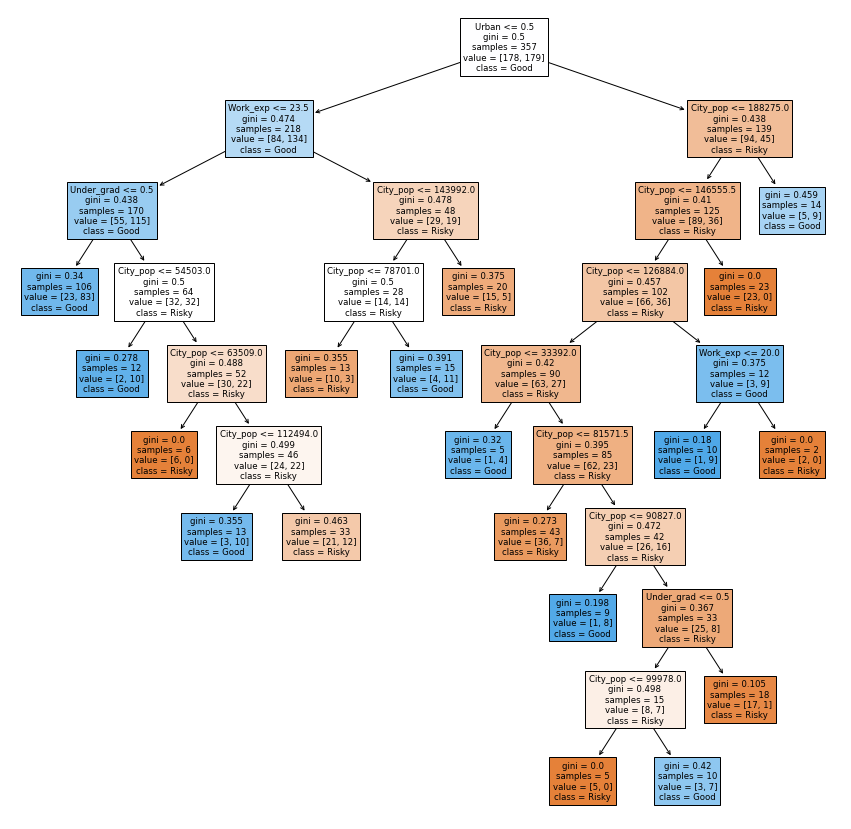

In [96]:
fn = x_train.columns
cn = ['Risky','Good']
plt.figure(figsize=(15,15))
tree.plot_tree(clf, feature_names=fn, class_names=cn, filled=True)

In [97]:
clf.feature_importances_

array([0.12744983, 0.        , 0.55296805, 0.11962078, 0.19996134])

In [98]:
feature_imp = pd.Series(clf.feature_importances_,index=fn).sort_values(ascending=False) 
feature_imp

City_pop      0.552968
Urban         0.199961
Under_grad    0.127450
Work_exp      0.119621
Marital       0.000000
dtype: float64